In [1]:
# import common libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# set the seaborn run command for font parameters
sns.set(rc={'font.weight': 'bold'}, font_scale=1.3)

# set parameters to remove erroenous warning messages that clutter the notebook
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

## Table of Contents

1. [Business Understanding](#business-understanding)
2. [Data Understanding](#data-understanding)
3. [Data Preparation](#data-preparation)
4. [Modeling](#modeling)
5. [Evaluation](#evaluation)
6. [Deployment](#deployment)

## Business Understanding
The City of Los Angeles is the 3rd largest City in the US.  Home to Hollywood

<br>
<br>

## Data Understanding
Agencies throughout the country participate in the FBI UCR Program and provide monthly summarized reports on ten Part I offenses known to law enforcement and reports on persons arrested. The Part I offenses, murder, rape, robbery, aggravated assault, human trafficking–commercial sex acts, human trafficking–involuntary servitude, burglary, motor vehicle theft, larceny-theft, and arson, are considered indicators of the level of crime occurring within the United States.<br>
<br>
Part I Offenses are ten serious crimes that occur on a regular basis and are likely to be reported to law enforcement. Part I Offenses are generally referred to as the “Crime Index” measurement. Part II Offenses represent “less serious” crime classifications.<br>
<br>

High Level Data Observations
- 932,140 observations of crimes committed
- Approximately 9% (81,078) result in an adult arrest
- Approximately .33% (3,057) result in a juvenile arrest
- Part 1 crimes - 372,823 crimes committed - 39% of data
- Part 2 crimes - 559,317 crimes committed - 61% of data
- Time Period - Full year data for 2020 - 2023 and Q1 for 2024<br>

There are 27 (omitting crime ID field) features included in the data cover the following topics:
<br>
- date, time, location and description of each crime comitted
- Victim demographics (Age, Sex, Descent)
- Type of location where crimes are committed (Apartment, Gas Station, etc)
- Weapon used in the crime
- Status of the crime (Arrest made or continued investigation)
- Geolocation

## Data Preparation
We will clean the data and then subset into 3 datasets:
- Part 1 crimes
- Part 2 crimes
- All crimes

### Data Cleaning
- Columns `CrmCd2`, `CrmCd3`, `CrmCd4` have between 95% - 99% missing values. We will drop these columns.
- For Part 1 crime, there are 53 unique crimes available in the data.  In order to evaluate crime trends, according to the 'national crime index', we will consolidate these crimes into the 10 Part 1 crimes.

    Part I offense classifications include:<br>
    1. Criminal Homicide<br>
    2. Rape<br>
    3. Robbery<br>
    4. Aggravated Assault<br>
    5. Burglary<br>
    6. Larceny-theft (except motor vehicle theft)<br>
    7. Motor Vehicle Theft<br>
    8. Arson<br>
    9. Human Trafficking, Commercial Sex Acts<br>
    10.Human Trafficking, Involuntary Servitude<br> 

### Feature Engineering
We will add the following features to improve data quality for more granular analysis:
- `Year` - Extract year from `Date Occurred`
- `Month` - Extract month from `Date Occurred`
- `Day` - Extract day from `Date Occurred`
- `Part of Day` - Descritize `Time Occurred` into 4 intervals (Morning, Afternoon, Evening, Night)

### Data Visualization
We will create an interactive map which shows crime activity per region.  


## Modeling
We will build a data model to predict the likelihood of an arrest being made for a crime.  We will use the following features:
- `Victim Age`  
- `Area Name`
- `Weapon Used`

## Evaluation
...

## Deployment
Theoretically, the model can be deployed in the field, providing real time prediction for crimes, to optimize resources and improve resopnse times.

As far as tech stack, we can use the [Django framework](https://www.djangoproject.com/), which is a high-level Python web framework that encourages rapid development and clean, pragmatic design.  We can also use the [Django REST framework(DRF)](https://www.django-rest-framework.org/) to create a RESTful API for the model.  In terms of infrastructure, we can deploy the Django application on [AWS Elastic Beanstack](https://docs.aws.amazon.com/elasticbeanstalk/latest/dg/create-deploy-python-django.html)

Please send me an email if you have any questions:  dan.herman@me.com


### Exploratory Data Analysis

### Read In the Data
The primary analysis will be for the City of Los Angeles.<br>  
We will also review data from New York and Chicago for comparison purposes.

In [2]:
# data for los angeles
data = pd.read_csv('../data/crime_data.csv')

# nyc = pd.read_csv('../data/nyc_crime.csv')
# ord = pd.read_csv('../data/ord_crime.csv')

print('There are {} rows and {} features in the dataset'.format(data.shape[0], data.shape[1]))

There are 932140 rows and 28 features in the dataset


### Pre-process the columns 
The date columns need to be formatted manually, as automated parsing at a row level will come with longer runtimes for 900,000+ rows

In [3]:
# remove spaces from all column names
data.columns = data.columns.str.replace(' ', '')

# fix the formatting for date and time, include hours minutes seconds
data['DateRptd'] = pd.to_datetime(data['DateRptd'], format='%m/%d/%Y %I:%M:%S %p')
data['DATEOCC'] = pd.to_datetime(data['DATEOCC'], format='%m/%d/%Y %I:%M:%S %p')

In [4]:
data.columns

Index(['DR_NO', 'DateRptd', 'DATEOCC', 'TIMEOCC', 'AREA', 'AREANAME',
       'RptDistNo', 'Part1-2', 'CrmCd', 'CrmCdDesc', 'Mocodes', 'VictAge',
       'VictSex', 'VictDescent', 'PremisCd', 'PremisDesc', 'WeaponUsedCd',
       'WeaponDesc', 'Status', 'StatusDesc', 'CrmCd1', 'CrmCd2', 'CrmCd3',
       'CrmCd4', 'LOCATION', 'CrossStreet', 'LAT', 'LON'],
      dtype='object')

### Data Quality Issue
There are 53 unique crime descriptions for part 1 crimes.  Part 1 crimes tend to fit under 10 categories.  We will consolidate these crimes into the 10 Part 1 crimes.

In [5]:
data.loc[data['Part1-2']==1]['CrmCdDesc'].value_counts().sample(5)

CrmCdDesc
THEFT, PERSON                                   4089
THEFT, COIN MACHINE - PETTY ($950 & UNDER)        22
THEFT, COIN MACHINE - GRAND ($950.01 & OVER)       8
SHOTS FIRED AT INHABITED DWELLING               1621
MANSLAUGHTER, NEGLIGENT                            8
Name: count, dtype: int64

In [6]:
pd.set_option('display.max_columns', None)

# search for crimes that have words associated with stolen vehicles
data.loc[data.CrmCdDesc.str.contains('|'.join(['HOMICIDE']))][['CrmCdDesc']].value_counts().to_frame()

,count
CrmCdDesc,
CRIMINAL HOMICIDE,1542


### Subset the data to Part 1 crimes
Before we subset the data, let's evaluate if the labels for the part 1 crimes are accuract, according the FBI national crime index

### Data Cleaning
Durring exploratory analysis, we found that the Part 1 crimes were not propertly labeled.  We will take the following steps to relable the data:
- Create a list of the Part 1 crimes
- Iterate through the `CrmCdDesc` column and determine if there is a match to the Part 1 crimes
- Create a new column `Match` to indicate if the crime is a Part 1 crime
- We will evaluate the `Match` column to ensure that the Part 1 crimes are properly labeled

![Part 1 Crimes](/Users/danherman/Desktop/los_angeles_crime/images/part1crimes.png)

In [7]:
# create a list of part 1 offenses
part_1_offenses = [
'Criminal Homicide',
'Rape',
'Robbery',
'Aggravated Assault',  
'Burglary',
'theft', 
'Motor Vehicle Theft',
'Arson',
'Human Trafficking, Commercial Sex Acts',
'Human Trafficking, Involuntary Servitude'
]

In [8]:
# convert all text strings above to upper case
part_1_offenses = [x.upper() for x in part_1_offenses]

In [9]:
part_1_offenses

['CRIMINAL HOMICIDE',
 'RAPE',
 'ROBBERY',
 'AGGRAVATED ASSAULT',
 'BURGLARY',
 'THEFT',
 'MOTOR VEHICLE THEFT',
 'ARSON',
 'HUMAN TRAFFICKING, COMMERCIAL SEX ACTS',
 'HUMAN TRAFFICKING, INVOLUNTARY SERVITUDE']

In [10]:
from tqdm import tqdm
tqdm.pandas()

def match_offense(row):
    for offense in part_1_offenses:
        if offense in row['CrmCdDesc']:
            return offense
    return None

data['new_label'] = data.progress_apply(match_offense, axis=1)

100%|██████████| 932140/932140 [00:13<00:00, 69308.09it/s]


In [11]:
part1 = data.loc[data['Part1-2']==1]

In [12]:
part1.loc[:,['CrmCdDesc', 'new_label']].sample(20)

,CrmCdDesc,new_label
732841,BURGLARY FROM VEHICLE,BURGLARY
794566,THEFT PLAIN - PETTY ($950 & UNDER),THEFT
302442,ROBBERY,ROBBERY
668615,VEHICLE - STOLEN,None
106076,THEFT PLAIN - PETTY ($950 & UNDER),THEFT
636642,VEHICLE - STOLEN,None
873311,VEHICLE - STOLEN,None
749384,BURGLARY FROM VEHICLE,BURGLARY
869022,THEFT PLAIN - PETTY ($950 & UNDER),THEFT
67040,THEFT PLAIN - PETTY ($950 & UNDER),THEFT


In [13]:
# show value counts, include missing values
part1['new_label'].value_counts(dropna=False)

new_label
THEFT                 183300
None                  137023
BURGLARY              119115
AGGRAVATED ASSAULT     65826
ROBBERY                36453
RAPE                    3983
ARSON                   2515
CRIMINAL HOMICIDE       1542
Name: count, dtype: int64

In [14]:
part1.loc[part1['new_label'].isnull()]['CrmCdDesc'].value_counts()

CrmCdDesc
VEHICLE - STOLEN                                            100225
BRANDISH WEAPON                                              14362
BIKE - STOLEN                                                 7499
VEHICLE - ATTEMPT STOLEN                                      3750
PICKPOCKET                                                    2784
VEHICLE, STOLEN - OTHER (MOTORIZED SCOOTERS, BIKES, ETC)      2140
SHOTS FIRED AT INHABITED DWELLING                             1621
SEXUAL PENETRATION W/FOREIGN OBJECT                           1293
ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER                  1060
ORAL COPULATION                                                697
SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO ANUS OTH        522
SHOTS FIRED AT MOVING VEHICLE, TRAIN OR AIRCRAFT               467
DRIVING WITHOUT OWNER CONSENT (DWOC)                           167
BOAT - STOLEN                                                  132
PURSE SNATCHING                                     

In [15]:
label_map = {'SODOMY':'RAPE'}

### Look for different word associations for each part 1 crimes
- gun
- firearm
- pistol
- rifle
- shotgun
- revolver
- simulated gun
- toy gun


In [16]:
# use progress bar to show how long it takes to iterate through large dataset
from tqdm import tqdm
tqdm.pandas()

def match_offense(desc):
    words = desc.split()
    for word in words:
        if any(offense.lower() in word.lower() for offense in part_1_offenses):
            return True
    return False

data['Match'] = data['CrmCdDesc'].progress_apply(match_offense)

100%|██████████| 932140/932140 [00:04<00:00, 206186.07it/s]


In [17]:
# sanity check the algorithm and the true labels
pd.set_option('display.max_rows', 100)

data.loc[
    (data['Match'] == False)& 
    (data['Part1-2'] == 1),
    ['CrmCdDesc', 'Part1-2','Match']
         ].value_counts().to_frame().reset_index().rename(columns={0: 'Count'}).sort_values(by='count', ascending=False)



,CrmCdDesc,Part1-2,Match,count
0,VEHICLE - STOLEN,1,False,100225
1,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",1,False,52677
2,BRANDISH WEAPON,1,False,14362
3,INTIMATE PARTNER - AGGRAVATED ASSAULT,1,False,12539
4,BIKE - STOLEN,1,False,7499
5,VEHICLE - ATTEMPT STOLEN,1,False,3750
6,PICKPOCKET,1,False,2784
7,"VEHICLE, STOLEN - OTHER (MOTORIZED SCOOTERS, B...",1,False,2140
8,SHOTS FIRED AT INHABITED DWELLING,1,False,1621
9,CRIMINAL HOMICIDE,1,False,1542


### Look at the type of locations crimes are committed

In [18]:
pd.set_option('display.max_rows', None)

(data.PremisDesc.value_counts()[3:]/len(data)).shape

(303,)

- There are 306 unique types of places where Part 1 crimes are committed
- Top 3 Premis Account for 54% of crimes
- After that, there are 300 unique premises that account for the remaining 46% of crimes



### Look at the Weapon used in the crime

In [19]:
data.WeaponDesc.value_counts()

WeaponDesc
STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)    172138
UNKNOWN WEAPON/OTHER WEAPON                        34916
VERBAL THREAT                                      23498
HAND GUN                                           19809
SEMI-AUTOMATIC PISTOL                               7135
KNIFE WITH BLADE 6INCHES OR LESS                    6740
UNKNOWN FIREARM                                     6493
OTHER KNIFE                                         5799
MACE/PEPPER SPRAY                                   3694
VEHICLE                                             3185
ROCK/THROWN OBJECT                                  2711
PIPE/METAL PIPE                                     2436
BOTTLE                                              2385
FOLDING KNIFE                                       2237
STICK                                               2224
CLUB/BAT                                            2062
KITCHEN KNIFE                                       1900
AIR PISTOL/REVOLVER/

- There are 79 unique values in the Weapon Description column 

### Feature Engineering

In [20]:

# extract the day month and year from DATEOCC
data['Year'] = data['DATEOCC'].dt.year
data['Month'] = data['DATEOCC'].dt.month
data['Day'] = data['DATEOCC'].dt.day

### Analyze the Data

In [21]:
data.columns

Index(['DR_NO', 'DateRptd', 'DATEOCC', 'TIMEOCC', 'AREA', 'AREANAME',
       'RptDistNo', 'Part1-2', 'CrmCd', 'CrmCdDesc', 'Mocodes', 'VictAge',
       'VictSex', 'VictDescent', 'PremisCd', 'PremisDesc', 'WeaponUsedCd',
       'WeaponDesc', 'Status', 'StatusDesc', 'CrmCd1', 'CrmCd2', 'CrmCd3',
       'CrmCd4', 'LOCATION', 'CrossStreet', 'LAT', 'LON', 'new_label', 'Match',
       'Year', 'Month', 'Day'],
      dtype='object')

In [22]:
len(list(data.loc[data['Part1-2']==1].CrmCdDesc.unique()))

53

In [23]:
pd.set_option('display.max_columns', 500)

data.loc[data['Part1-2']==1].CrmCd.nunique()

53

### Create an Interactive Chloropleth Map
These maps are quite challenging to build and there is minimal documentation available.<br>
I found a good tutorial that can serve as a companion, reviewing 3 different types of maps<br>
[Interactive Maps Tutorial](https://medium.com/geekculture/three-ways-to-plot-choropleth-map-using-python-f53799a3e623) <br>

We will use the Folium Python package.  There are 2 steps involved in building this map 
<br>
1.  Acquire the geojson data -  This data serves as the boundaries for the map and is an essential layer, where the data in the geojson file, must match the data in the dataset in the `AREANAME` column.  You can create geojson data, which is quite challenging.  Or you can look to get the file from an existing project.  If you're working on a government dataset, you can find the appropriate geojson data on GitHub <br><br>

2.  Colorscale effect - Create a dataframe with 2 columns, namely `AREANAME` and count of crimes in the region<br>
*Once again - the `AREANAME` must match the geojson data for the map to render correctly*<br>
<br>
Geojson data is widely available on GitHub.<br>


### We will subset the data first
This step is fairly simple

In [24]:
# use groupby to agregate the count of crimes in each of the 21 police districts, 
area_names = data.groupby('AREANAME').agg({'AREANAME': 'count'}).rename(columns={'AREANAME':'Count'}).reset_index()

# rename columns for interpretability
area_names = area_names.rename(columns={'AREANAME':'name','Count':'count'})

# change value in index 8 column 0 to North Hollywood and index 18 to West Los Angeles
area_names.iloc[8,0] = 'North Hollywood'
area_names.iloc[18,0] = 'West Los Angeles'

# show the dataframe confirming the correct format and data structure
area_names

,name,count
0,77th Street,58353
1,Central,63133
2,Devonshire,38309
3,Foothill,30899
4,Harbor,38491
5,Hollenbeck,34493
6,Hollywood,49080
7,Mission,37155
8,North Hollywood,46993
9,Newton,46096


### Get the geojason file

In [25]:
#Import modules for acquiring geojson
from urllib.request import urlopen
import json

#Import geojson from Github
with urlopen('https://raw.githubusercontent.com/sidneykung/LA_crime_forecasting/main/data/LAPD_Divisions.json') as response:
    lapd_divisions = json.load(response)  #Collect geojson data from Github

In [26]:
#import folium
import folium

#Creaate a map object for choropleth map
#Set location to your location of interest (latitude and longitude )
map0 = folium.Map(location=[34.0549,-118.2426], zoom_start=10)

#Create choropleth map object with key on TOWNNAME
folium.Choropleth(geo_data = lapd_divisions,#Assign geo_data to your geojson file
    name = "choropleth",
    data = area_names,#Assign dataset of interest
    columns = ['name','count'],#Assign columns in the dataset for plotting
    key_on = 'feature.properties.name',#Assign the key that geojson uses to connect with dataset
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.5,
    legend_name = 'LAPD Division').add_to(map0)

#Create style_function
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}

#Create highlight_function
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}

#Create popup tooltip object
NIL = folium.features.GeoJson(
    lapd_divisions,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['name'],
        aliases=['LAPD Division'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")))

#Add tooltip object to the map
map0.add_child(NIL)
map0.keep_in_front(NIL)
folium.LayerControl().add_to(map0)

# load the map
map0

In [27]:
# save the html to data folder
map0.save('../data/choropleth_map.html')

___

### We will analyze the data in 3 different ways
1.  Analyze Part 1 crimes - 372,823 crimes committed
2.  Analyze Part 2 crimes - 559,317 crimes committed
3.  Analyze all crimes - 932,140 crimes committed

### later on we will compare data to other major cities (NYC & Chicago)

In [28]:
# show min max DATEOCC in tupel
print('Dataset Date Range:')
display(data['DATEOCC'].agg(['min', 'max']))


Dataset Date Range:


min   2020-01-01
max   2024-04-15
Name: DATEOCC, dtype: datetime64[ns]

In [29]:
# percent of crimes that are Part 1
data.loc[
    (data['Part1-2'] == 1)
].shape[0]/len(data)

0.5897794322741219

In [30]:
# percent of crimes that are Part 2
data.loc[
    (data['Part1-2'] == 2)
].shape[0]/len(data)

0.41022056772587806

In [31]:
# Subset the data by 2 criteria: 
data = data.loc[
    (data['Year'] != 2024)& # 1 remove the 2024 year, as the data is incomplete 
    (data['Part1-2']  ==  2) # 2 show crimes in part 1 or 2
                ]

print('There are',data.shape[0],'observations in the subset')

There are 361232 observations in the subset


In [32]:
print('The top 25 crimes committed represent {:.2%} of the dataset'.format((data['CrmCdDesc'].value_counts()[:25]/len(data)).sum()))

The top 25 crimes committed represent 95.57% of the dataset


### Plot the top 25 crimes from 2020 - 2023


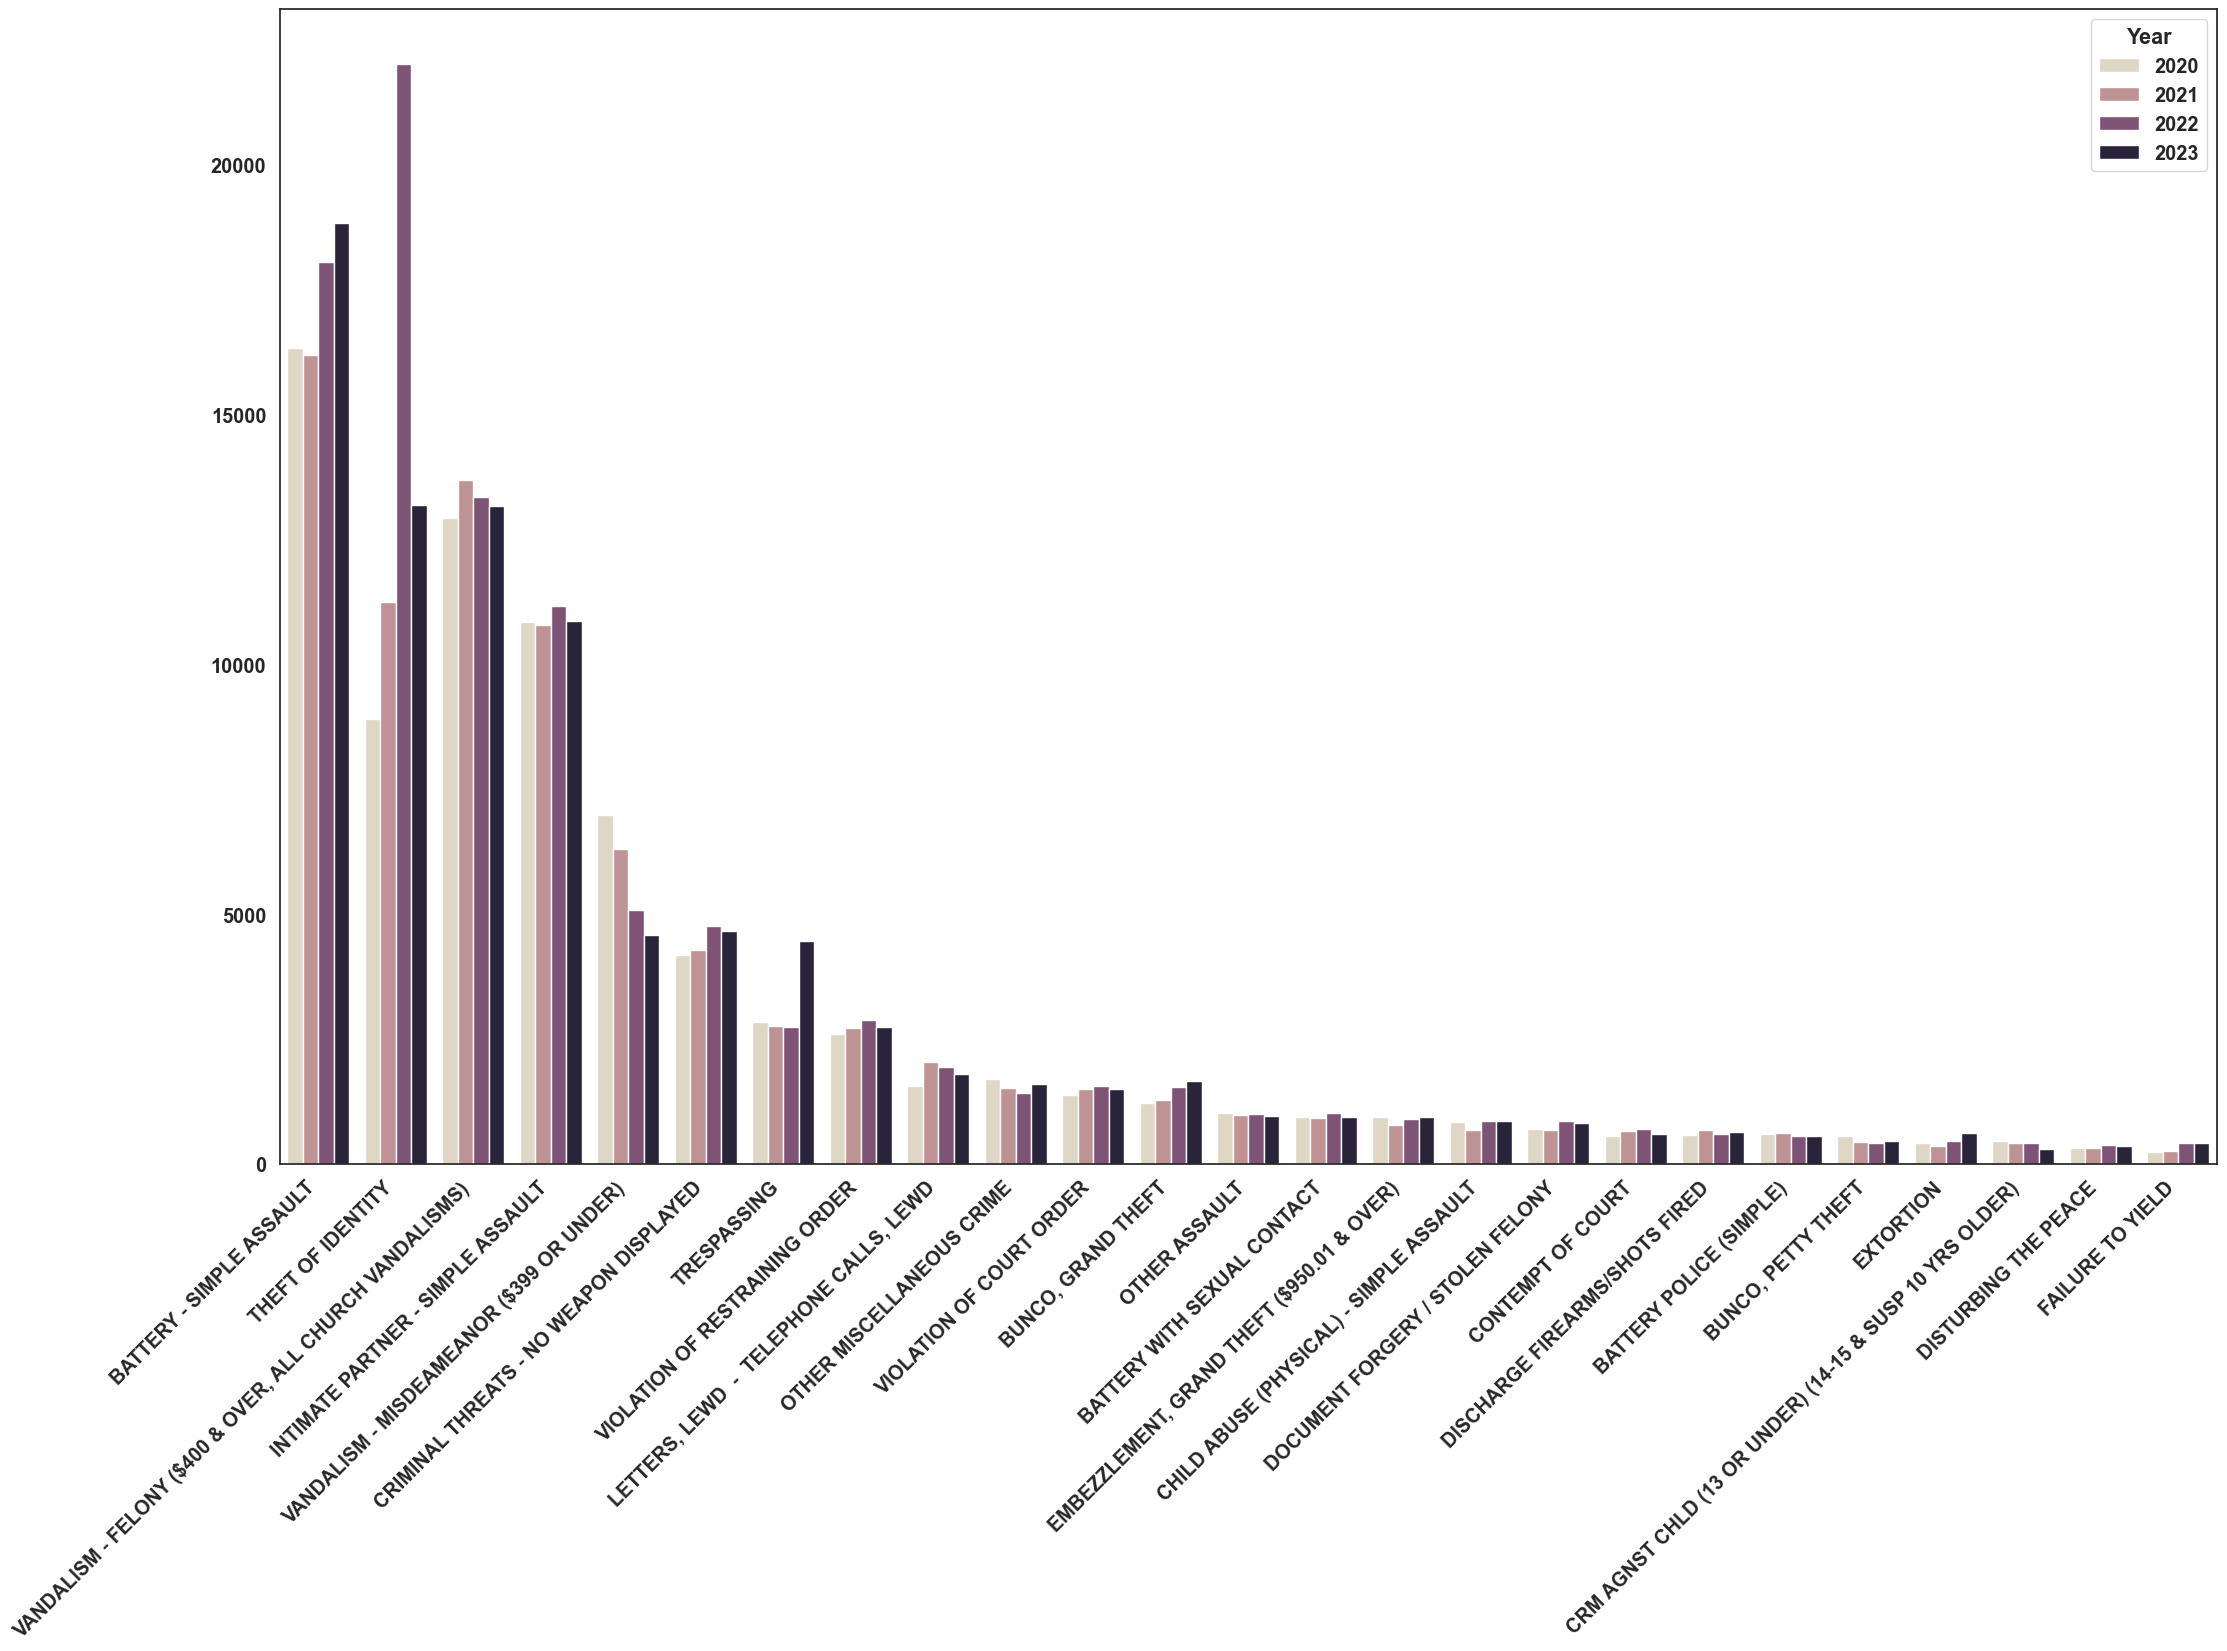

In [33]:
# set white background
sns.set_style('white')

# Get the top 25 crime descriptions
top_25 = data['CrmCdDesc'].value_counts().index[:25]

# Filter the data to only include rows with the top 25 crime descriptions
top_25_data = data[data['CrmCdDesc'].isin(top_25)]

# Create the bar plot
plt.figure(figsize=(25, 15))
sns.countplot(data=top_25_data, x='CrmCdDesc', hue='Year', palette='ch:s=-.2,r=.6', order=top_25)

# Get current axes
ax = plt.gca()

# Rotate and align x-axis labels for readability
for item in ax.get_xticklabels():
    item.set_rotation(45)
    item.set_ha('right')

# remove count and x label
plt.ylabel('')
plt.xlabel('')

# Show the plot
plt.show()